# KNN text classification from ICLR 2019 reviews

Using ICLR 2019 reviews from openreview, KNN was used in this notebook, using the decision as label for a review

In [1]:
import pandas as pd
import ast # Library to parse code, since replies were saved as a list format in the csv
from collections import Counter
import random
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from matplotlib import pyplot as plt
import string
import re
import numpy as np
from collections import Counter

%matplotlib inline

#### Path to data that contains csv names for iclr conferences

In [2]:
path_to_data = "iclr_urls.csv"
iclr_conf_data = pd.read_csv(path_to_data) 
iclr_conf_data.head()

,conference,conference_url,n_papers,comments
0,iclr2013_conference,ICLR.cc/2013/conference/-/submission,67,NaN
1,iclr2014_conference,ICLR.cc/2014/conference/-/submission,69,without decisions data
2,iclr2014_workshop,ICLR.cc/2014/workshop/-/submission,19,without decision data
3,iclr2016_workshop,ICLR.cc/2016/workshop/-/submission,125,without decision data
4,iclr2017_conference,ICLR.cc/2017/conference/-/paper.*/acceptance,490,NaN


#### Showing conference where data is available from the iclr_ulrs.csv

In [3]:
iclr_conf_data['conference']

0              iclr2013_conference
1              iclr2014_conference
2                iclr2014_workshop
3                iclr2016_workshop
4              iclr2017_conference
5                iclr2017_workshop
6     iclr2018_conference_decision
7       iclr2018_workshop_decision
8     iclr2019_conference_decision
9         iclr2019_workshop_drlmsp
10           iclr2019_workshop_rml
11           iclr2019_workshop_lld
12        iclr2019_workshop_dgmhsd
Name: conference, dtype: object

#### Data for iclr 2019 is divided between the conference and its workshops

In [20]:
iclr_conf_data['conference'].iloc[8]

'iclr2019_conference_decision'

#### sing ICLR 2019 conference data

In [21]:
iclr19_dataset = pd.read_csv(iclr_conf_data['conference'].iloc[8]+".csv")
iclr19_dataset.head()

,title,authors,emails,decision,abstract,pdf,replies
0,Improved Gradient Estimators for Stochastic Di...,"['Evgeny Andriyash', 'Arash Vahdat', 'Bill Mac...","['eandriyash@dwavesys.com', 'avahdat@dwavesys....",Reject,In many applications we seek to optimize an ex...,/pdf/ae83aaf46d270292953663aef66b0b6342cf97b4.pdf,"[[('title', 'Sensible ideas scattered througho..."
1,Looking for ELMo's friends: Sentence-Level Pre...,"['Samuel R. Bowman', 'Ellie Pavlick', 'Edouard...","['bowman@nyu.edu', 'ellie_pavlick@brown.edu', ...",Reject,Work on the problem of contextualized word rep...,/pdf/05feb28cf06d05de51879e7f22f79a7fc78e8272.pdf,"[[('comment', 'Additional note on the final de..."
2,Identifying Bias in AI using Simulation,"['Daniel McDuff', 'Roger Cheng', 'Ashish Kapoor']","['damcduff@microsoft.com', 'rocheng@microsoft....",Reject,"Machine learned models exhibit bias, often bec...",/pdf/32ac04bc91ee838d7786842109dc4550371f657f.pdf,"[[('title', 'Important problem, interesting so..."
3,Padam: Closing the Generalization Gap of Adapt...,"['Jinghui Chen', 'Quanquan Gu']","['jc4zg@virginia.edu', 'qgu@cs.ucla.edu']",Reject,"Adaptive gradient methods, which adopt histori...",/pdf/bebe4e072efb718a2cb702809a8f9297eb631f4a.pdf,"[[('title', 'Meta-review'), ('metareview', 'Th..."
4,Visual Semantic Navigation using Scene Priors,"['Wei Yang', 'Xiaolong Wang', 'Ali Farhadi', '...","['wyang@ee.cuhk.edu.hk', 'xiaolonw@cs.cmu.edu'...",Accept (Poster),How do humans navigate to target objects in no...,/pdf/289b7fed4ba41a9243344c4dfbbbc985f0ce6d20.pdf,"[[('title', 'meta-review'), ('metareview', ""Th..."


#### 1419 papers are avaible from the openreview website

In [6]:
replies = iclr19_dataset['replies']
print("Number of papers: " + str(len(replies))) 
replies[:5]

Number of papers: 1419


0    [[('title', 'Sensible ideas scattered througho...
1    [[('comment', 'Additional note on the final de...
2    [[('title', 'Important problem, interesting so...
3    [[('title', 'Meta-review'), ('metareview', 'Th...
4    [[('title', 'meta-review'), ('metareview', "Th...
Name: replies, dtype: object

#### There are only 3 possible classes to tag reviews,classes differ a lot in its numbers

In [22]:
decision_options = Counter(iclr19_dataset['decision'])
decision_options

Counter({'Reject': 917, 'Accept (Poster)': 478, 'Accept (Oral)': 24})

In [8]:
decision_labels = {'Reject': 0, "Accept (Poster)": 1, "Accept (Oral)": 2}
decision_labels

{'Reject': 0, 'Accept (Poster)': 1, 'Accept (Oral)': 2}

In [9]:
def match_reviews_and_decision(df_venue, labels):
  """Creates and lists of lists containing a review an its decision
  
  Args:
    df_venue (pandas dataframe): Contains data from a venue where each row represents
    a paper that have title, authors, emails, decision, abstract, pdf and replies fields.
    labels (dictionary): Maps a string to a number that encodes the decision as an integer
  Returns:
    A lists of pairs where the first elements are the decision encoded with the labels
    and the second elements is the review.
    
  """

  decision_review = []
  for index, row in df_venue.iterrows():
    comments = ast.literal_eval(row['replies'])
    for comment in comments:
      if comment[1][0] == "review": # filtering comments that are reviews only
        decision_review.append([labels[row['decision']],comment[1][1]])
  return decision_review

In [10]:
decision_review = match_reviews_and_decision(iclr19_dataset, decision_labels)
len(decision_review)

4332

#### Defining cleaning method includes punctuation marks, stop words &amp; digits.

In [24]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    processed = re.sub(r"\d+","",normalized)
    y = processed.split()
    return y

#### Cleaning the reviews and extracting tf-idf features using scikit-learn library

In [29]:
def preprocess_data(df_venue):
  """Does the preprocessing applying the clean function and the
  TfidVectorizer using the english stopwords
  
  Args:
    df_venue (pandas dataframe): Contains data from a venue where each row represents
    a paper that have title, authors, emails, decision, abstract, pdf and replies fields.
    
  Returns:
    X (sparse matrix, [n_samples, n_features]): Tf-idf-weighted document-term matrix.
    y (lists of integers): labels encoded as integers.

  """

  train_clean_sentences = []
  y = np.array([y[0] for y in decision_review])

  for line in decision_review:
    line = line[1].strip()
    cleaned = clean(line)
    cleaned = ' '.join(cleaned)
    train_clean_sentences.append(cleaned)
    
  vectorizer = TfidfVectorizer(stop_words='english')
  X = vectorizer.fit_transform(train_clean_sentences)
  
  return X, y

In [30]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    y_true = [int(x) for x in y_true]
    y_pred = [int(x) for x in y_pred]
    
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [31]:
X, y = preprocess_data(decision_review)

#### Setting k to 3 and printing the confusion matrix for 10 k folds

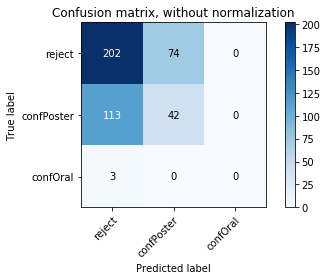

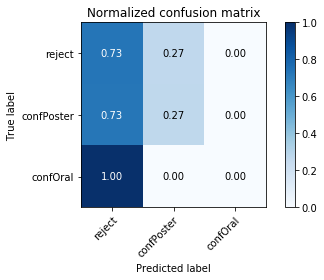

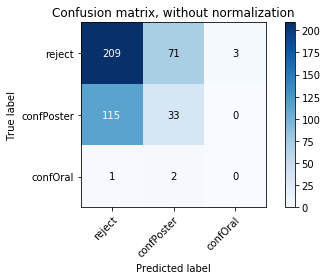

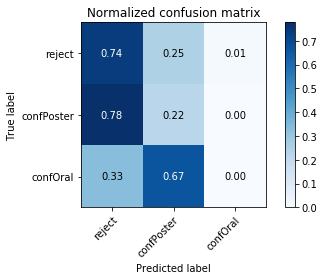

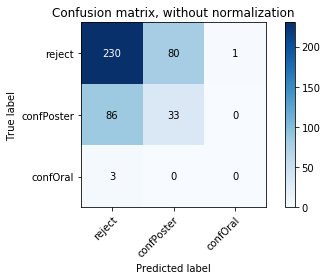

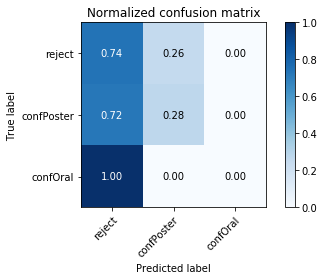

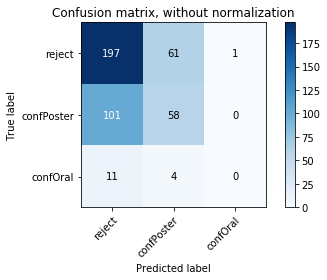

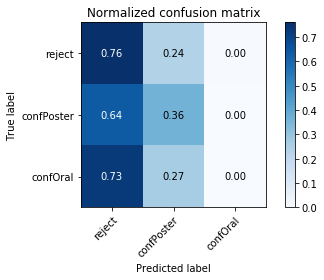

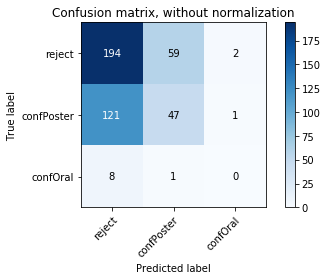

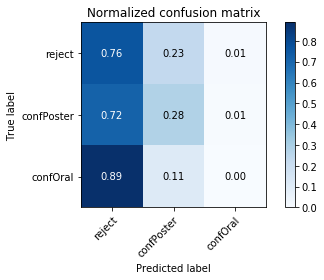

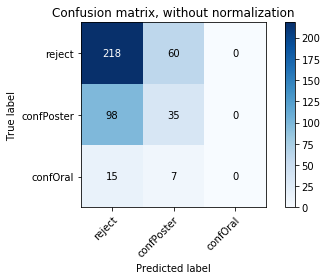

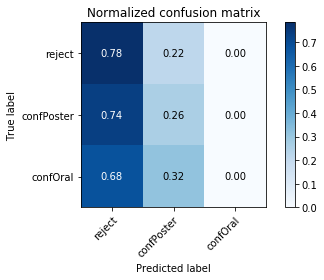

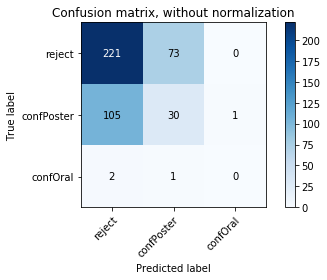

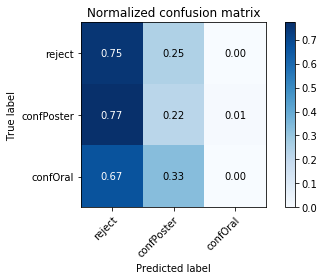

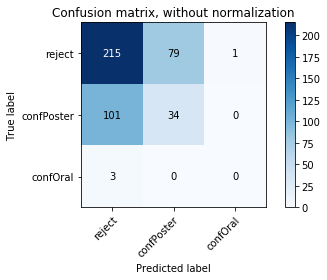

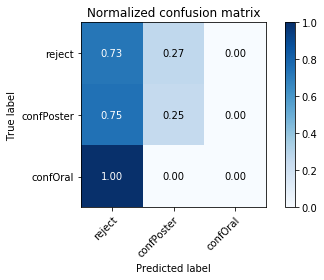

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


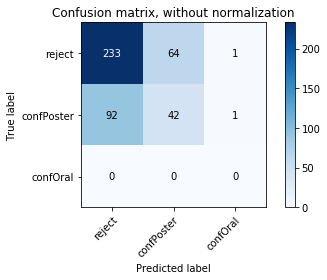

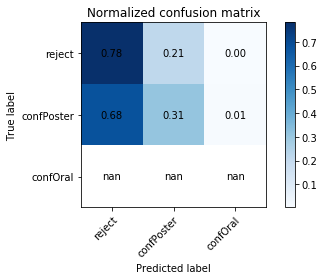

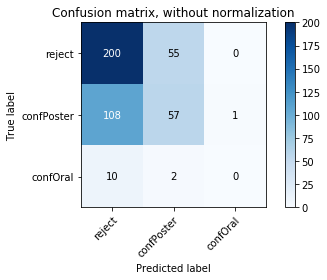

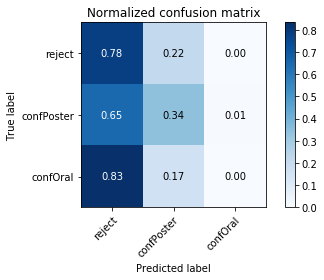

In [32]:
modelknn = KNeighborsClassifier(n_neighbors=3)

scores = []
cv = KFold(n_splits=10, random_state=420, shuffle=False)
class_names = np.array(["reject", "confPoster", "confOral"])

for train_index, test_index in cv.split(X):
  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
  modelknn.fit(X_train,y_train)
  scores.append(modelknn.score(X_test, y_test))    
  np.set_printoptions(precision=2)
  y_pred = modelknn.fit(X_train, y_train).predict(X_test)
  # Plot non-normalized confusion matrix
  plot_confusion_matrix(y_test, y_pred, classes=class_names, title="Confusion matrix, without normalization")
  # Plot normalized confusion matrix
  plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, title="Normalized confusion matrix")
  plt.show()

In [ ]:
scores

In [18]:
# Perform 10-fold cross validation
scores = cross_val_score(modelknn, X, y, cv=10)
print("Cross-validated scores:", scores)
print("Avg score: ", sum(scores)/len(scores))

Cross-validated scores: [0.56 0.56 0.57 0.62 0.59 0.61 0.56 0.57 0.61 0.62]
Avg score:  0.5877525449813333
